In [ ]:
#step 0.1 匯入所需模組
import pandas as pd
import numpy as np
# from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers

# Data process

In [2]:
#step 0.2 讀取IMDb資料集目錄,以read_file() function, toolFuction.py
# import toolFuction
df = pd.read_csv('A3_201902_0510.csv')
df = df.apply(pd.to_numeric, errors='coerce') 

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['dilute_ratio'] = df['input_flow'] / df['dilute_dmf']  #生成新的欄位(稀釋DMF添加比例)
df12 = df['input_flow'] > 1200                                #將總入料量取出介於2200~2800的數值 -->取出來
df30 = df['input_flow'] < 3000
output_viscosity_above_140 = df['output_viscosity'] > 140  #將脫泡後黏度取出大於140的數值 -->取出來
output_viscosity_above_250 = df['output_viscosity'] < 250
luwa_amp_above_6 = df['Luwa_amp'] > 6
TOP_temp_above_75 = df['TOP_temp'] > 75
df = df.loc[(df12)&(df30) & (output_viscosity_above_140) & (output_viscosity_above_250) & (luwa_amp_above_6) & (TOP_temp_above_75)]

In [4]:
df.describe()

,date,input_flow,input_viscosity,dilute_dmf,SL_temp,SL_1st_flow,SL_2nd_flow,SL_3rd_flow,CDL_1st_temp,CDL_2nd_temp,CLD_3rd_temp,TOP_temp,vacuum,Luwa_amp,Stamo_amp,output_viscosity,dilute_ratio
count,0.0,61582.000000,61582.000000,61582.000000,61582.000000,61580.000000,61582.000000,61582.000000,61582.000000,61582.000000,61582.000000,61582.000000,61582.000000,61582.000000,61580.000000,61582.000000,61582.000000
mean,NaN,1741.014703,31.813813,283.252933,131.827962,69.395478,74.432406,76.811888,101.456914,104.605167,111.734926,80.315019,110.013647,11.662606,15.466324,192.613559,6.173279
std,NaN,266.904725,3.409748,36.966217,0.154027,11.379272,18.261532,13.332690,4.414494,3.750942,3.523956,0.576418,0.139471,1.772700,7.721228,11.133183,0.675637
min,NaN,1396.080000,28.080000,190.491867,129.430000,41.630000,23.680000,58.650000,83.300000,94.800000,22.360000,76.940000,107.610000,8.200000,0.000000,140.010000,0.834243
25%,NaN,1635.166737,30.310000,260.070000,131.800000,60.000000,55.050000,65.000000,99.600000,102.890000,109.260000,79.980000,109.940000,10.200000,18.590000,186.310000,5.701042
50%,NaN,1699.072353,31.110000,279.980000,131.830000,65.040000,79.800000,79.960000,103.300000,104.540000,112.080000,80.357777,110.000000,11.310000,19.120000,192.590000,6.152058
75%,NaN,1758.067500,32.380000,299.060000,131.900000,79.970000,84.940000,84.993330,104.254908,107.700000,113.300003,80.690000,110.090000,12.859571,19.600000,198.420000,6.620947
max,NaN,2999.950000,68.730000,2088.483887,139.290000,134.160000,139.560000,140.340000,131.680000,132.390000,131.397629,84.990000,112.676086,37.500000,21.200000,249.920000,10.727520


In [5]:
columns = list(df.columns)
columns.remove('date') 
columns.remove('input_flow')    # 與 total_flow重複
columns.remove('Stamo_amp')      #要提前預測，所以將 Stamo_amp 移除
columns.remove('dilute_dmf')     #已建立新的feature(dilute_ratio)，故移除 dilute_dmf
# columns.remove('output_viscosity') #要預測的 label，所以移除

In [6]:
#刪除含缺失值的 row
df[columns].isna().sum()
df1 = df[columns].dropna()

In [7]:
dfx = df1.drop('output_viscosity', axis=1)
dfy = df1['output_viscosity']

In [8]:
df2=dfx.values
df3=dfy.values
print(df2.shape, df3.shape)

(61580, 12) (61580,)


In [9]:
scaler = StandardScaler()
X_scaled_dataset = scaler.fit_transform(df2)
Y_scaled_dataset = scaler.fit_transform(df3.reshape(-1, 1))

xdf=X_scaled_dataset
ydf=Y_scaled_dataset
print(xdf[:,-1])
print(ydf)

[-1.856468   -1.84253809 -1.82822777 ...  0.32506669  0.19980224
  0.2593135 ]
[[ 1.17545908]
 [ 1.15569839]
 [ 1.06857174]
 ...
 [-1.37142765]
 [-1.25375513]
 [-1.23669708]]


In [10]:
window_size=3
#抓取window_size的資料作為觀察資料(x), 下一筆作為預測資料(y)
def window_data(data,data2, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size+1])
        y.append(data2[i+window_size])
        
        i += 1+ window_size
    assert len(X) ==  len(y)
    return X, y

In [11]:
X, y = window_data(xdf,ydf, window_size)

In [12]:
X1 = np.array(X)
y2 =np.array(y)

In [13]:
X1.shape

(15395, 4, 12)

In [14]:
Conv1D_trainX = X1[:12000]
Conv1D_trainY = y2[:12000]
Conv1D_testX = X1[12000:]
Conv1D_testY = y2[12000:]
print(Conv1D_trainX.shape, Conv1D_trainY.shape )

(12000, 4, 12) (12000, 1)


In [15]:
Conv1D_testX.shape

(3395, 4, 12)

# Model training

In [16]:
from sklearn.model_selection import train_test_split
seed = 0
X_train, X_vali, y_train, y_vali = train_test_split(Conv1D_trainX, Conv1D_trainY, 
                                                    test_size=0.1, random_state=seed, shuffle=True)

In [17]:
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(4, 12)))
model.add(Activation('relu'))
# model.add(Conv1D(32, 3))
model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(64, 3))
model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(128, 3, input_shape=(12, 1)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
# model2.add(Dense(128, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
model.compile(loss="mae", optimizer="adam")

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 32)             1184      
_________________________________________________________________
activation_1 (Activation)    (None, 2, 32)             0         
_________________________________________________________________
activation_2 (Activation)    (None, 2, 32)             0         
_________________________________________________________________
activation_3 (Activation)    (None, 2, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [21]:
filepath = './1dcnn_model/7t2-{epoch:02d}-{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, period=5, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, verbose = 1) 
result=model.fit(X_train, y_train, batch_size=64, epochs=500, verbose=1, 
                 validation_split=0.3, callbacks=[early_stopping, checkpoint])

Train on 7559 samples, validate on 3241 samples
Epoch 1/500
7559/7559 [==============================] - 0s 62us/step - loss: 0.3584 - val_loss: 0.3411
Epoch 2/500
7559/7559 [==============================] - 0s 57us/step - loss: 0.3542 - val_loss: 0.3318
Epoch 3/500
7559/7559 [==============================] - 0s 55us/step - loss: 0.3471 - val_loss: 0.3308
Epoch 4/500
7559/7559 [==============================] - 0s 57us/step - loss: 0.3427 - val_loss: 0.3329
Epoch 5/500
7559/7559 [==============================] - 0s 56us/step - loss: 0.3371 - val_loss: 0.3224

Epoch 00005: val_loss improved from inf to 0.32238, saving model to ./1dcnn_model/7t2-05-0.3224.hdf5
Epoch 6/500
7559/7559 [==============================] - 0s 63us/step - loss: 0.3351 - val_loss: 0.3153
Epoch 7/500
7559/7559 [==============================] - 0s 61us/step - loss: 0.3275 - val_loss: 0.3205
Epoch 8/500
7559/7559 [==============================] - 0s 59us/step - loss: 0.3270 - val_loss: 0.3163
Epoch 9/500
7559/7

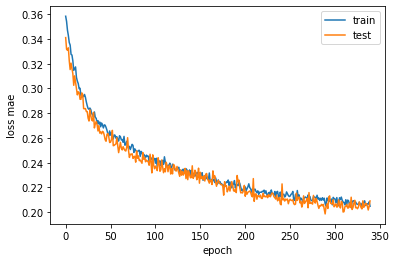

In [22]:
%matplotlib inline
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.ylabel('loss mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [24]:
y_pred_std = model.predict(X_vali)
y_pred = scaler.inverse_transform(y_pred_std).reshape(1200)
y_test_r = scaler.inverse_transform(y_vali).reshape(1200)

In [25]:
from sklearn.metrics import r2_score 
r2_score(y_test_r, y_pred)

0.888774706793806

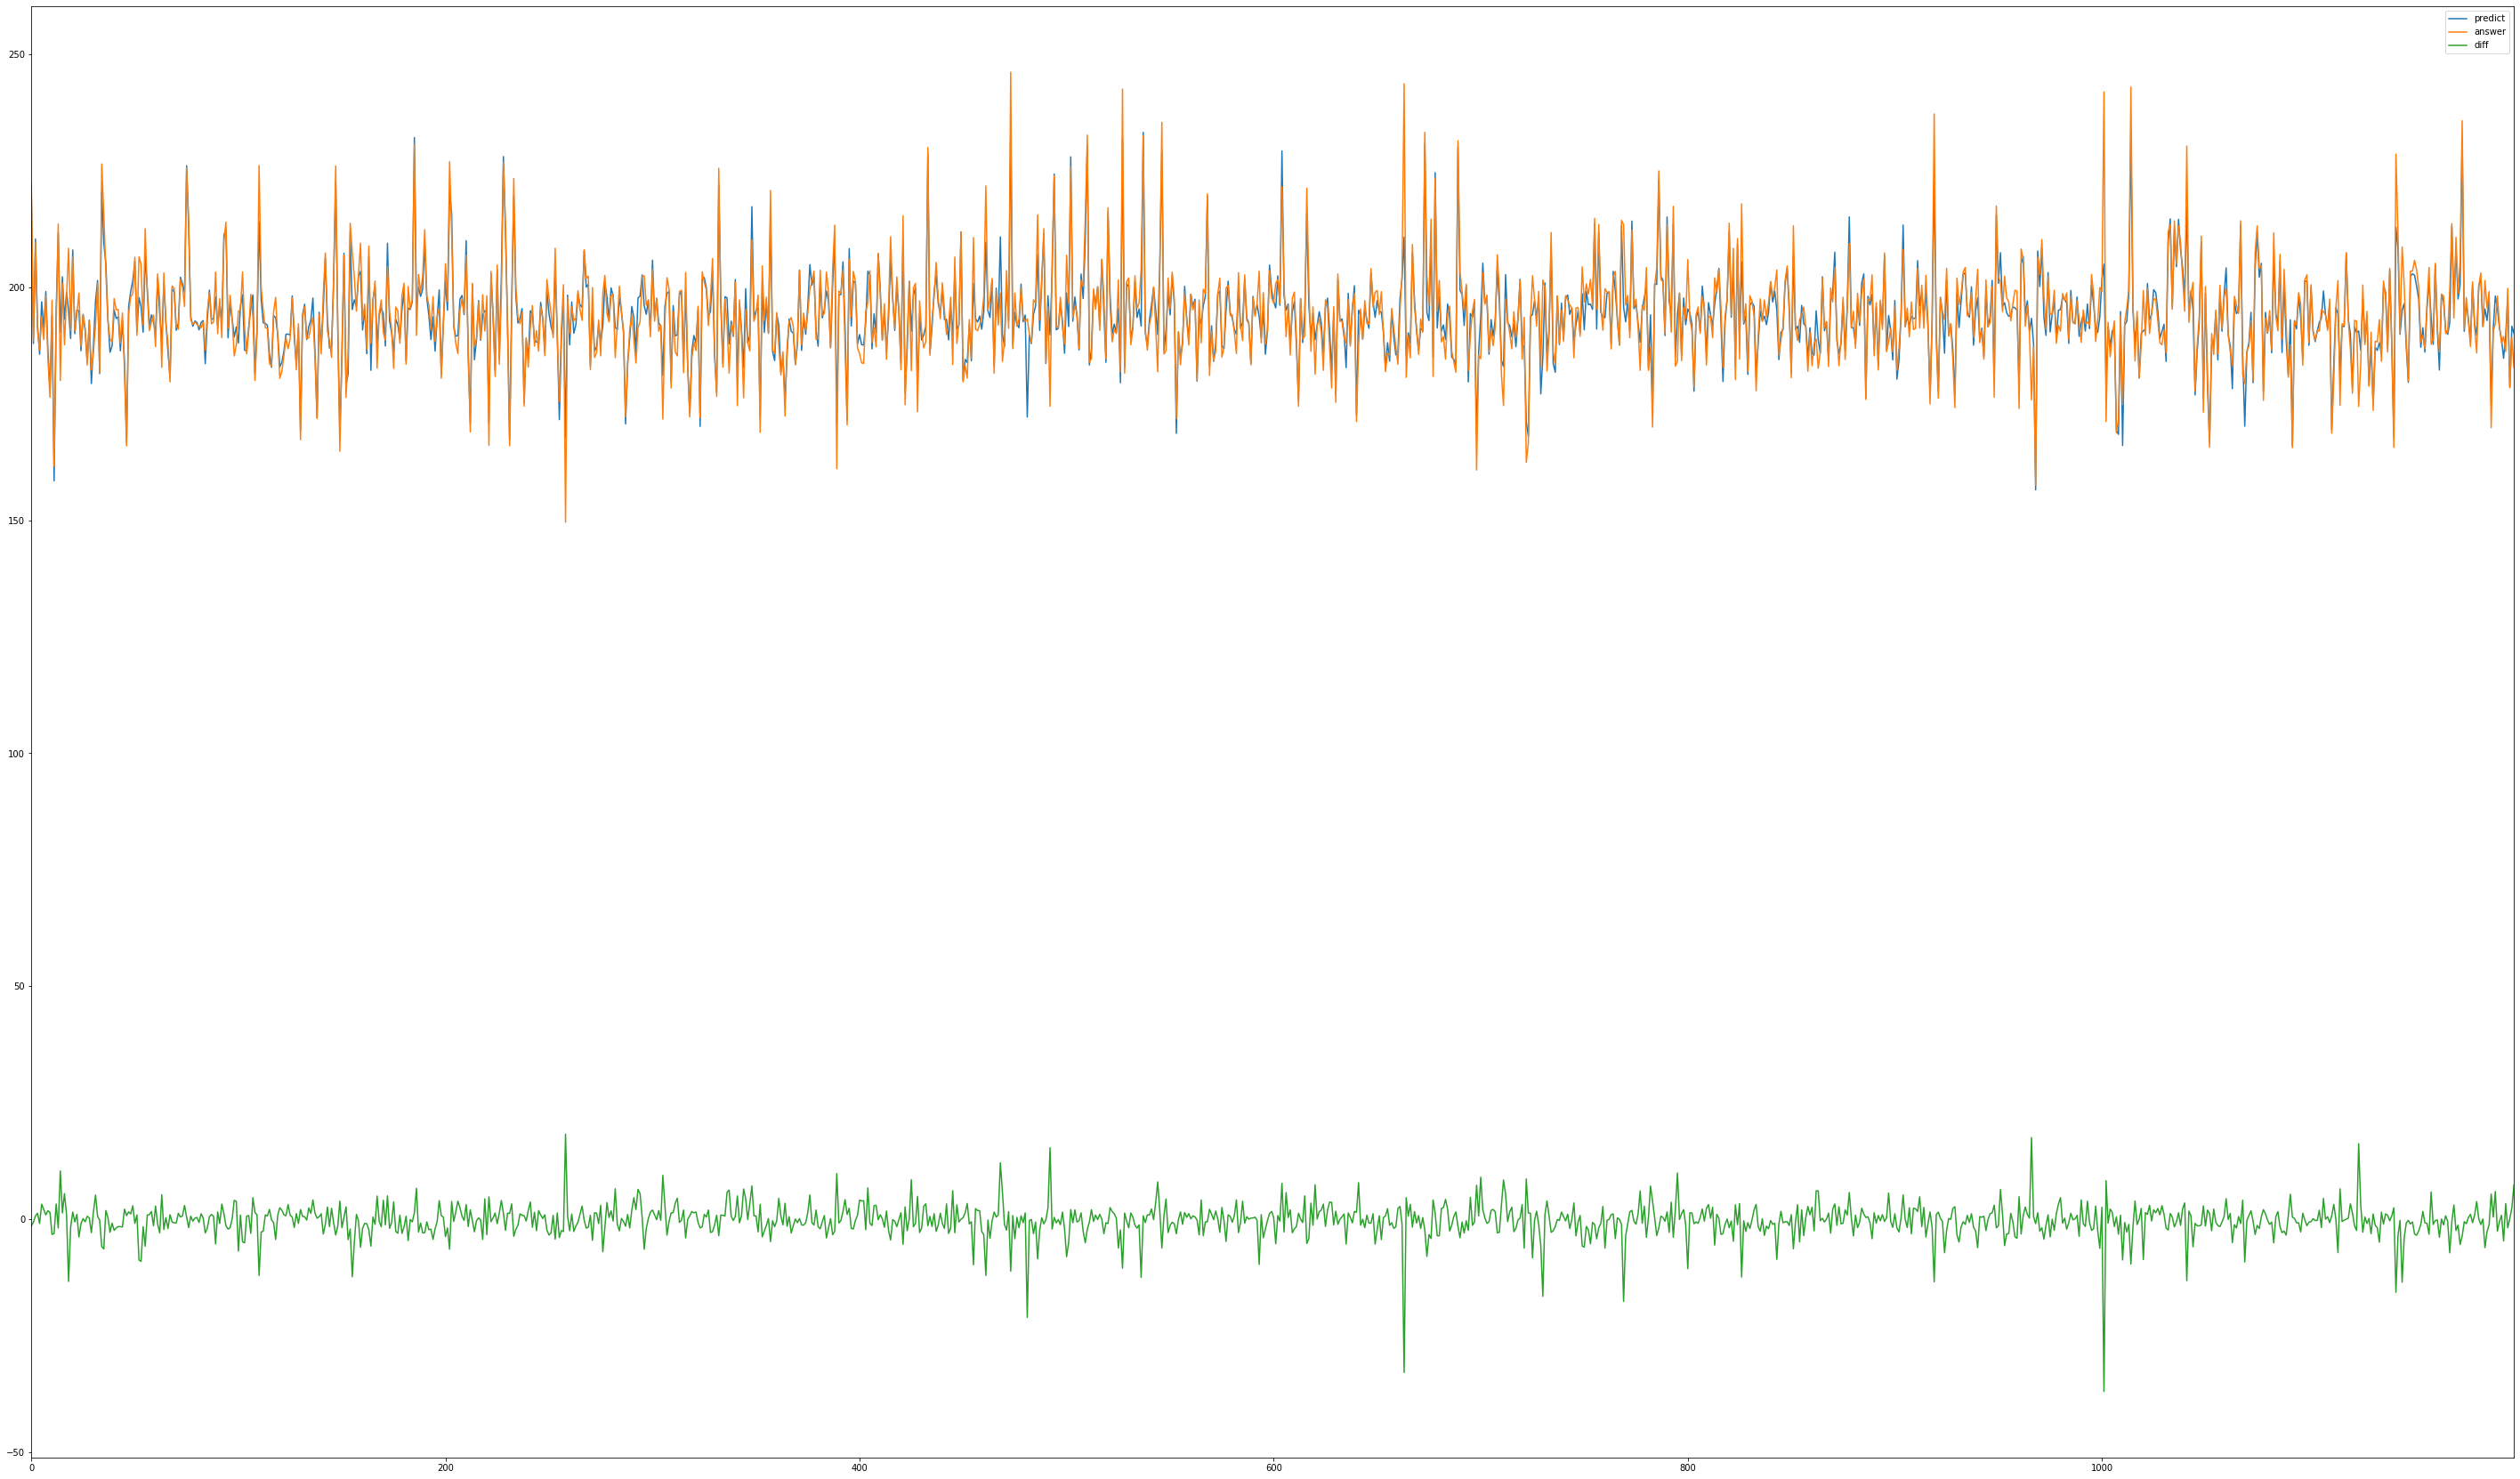

In [26]:
result_dff = pd.DataFrame({
    'predict': y_pred,
    'answer': y_test_r,
    'diff': y_pred - y_test_r
})
%matplotlib inline
result_dff = result_dff.reset_index(drop=True)
result_dff.plot(fontsize=10,figsize=(50,30))

In [28]:
y_test_std = model.predict(Conv1D_testX)
y_test = scaler.inverse_transform(y_test_std).reshape(3395)
y_answer = scaler.inverse_transform(Conv1D_testY).reshape(3395)

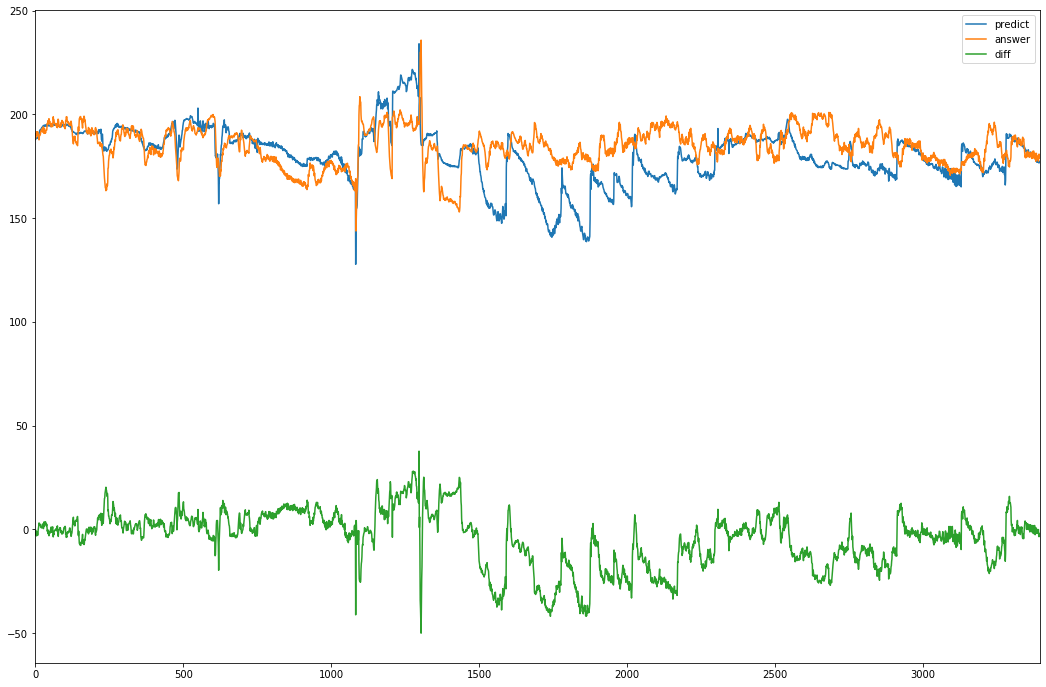

In [29]:
result_dff = pd.DataFrame({
    'predict': y_test,
    'answer': y_answer,
    'diff': y_test - y_answer
})
%matplotlib inline
result_dff = result_dff.reset_index(drop=True)
result_dff.plot(fontsize=10,figsize=(18,12))